# 利用 AWS Sagemaker BlazingText 对不均衡文本进行多分类

## 过采样实验（超参数优化）

Step 0 - Setup；
Step 1 - 数据集分析；
Step 2 - 数据预处理；
Step 3 - 处理样本不均衡；
Step 4 - 

## Step 0 - Setup

指定用于存放训练和模型数据的S3存储桶和前缀。 

并指定 IAM 角色用于授予SageMaker访问数据的权限。 

In [1]:
import sagemaker
from sagemaker import get_execution_role
import json
import boto3

sess = sagemaker.Session()

role = get_execution_role()
print(role)

bucket = 'sagemaker-workshop-demos'
prefix = 'unbalanced-text-multi-classification'

arn:aws:iam::528326054333:role/service-role/AmazonSageMaker-ExecutionRole-20190827T175137


## Step 1 - 数据集分析

In [2]:
import pandas as pd

step1_df = pd.read_csv('original_dataset/dataset.csv')
print("行数：" + str(step1_df.shape[0]))
step1_df.head()

行数：188020


,label,title,abstract
0,1,E. D. Abbott Ltd,Abbott of Farnham E D Abbott Limited was a Br...
1,1,Schwan-Stabilo,Schwan-STABILO is a German maker of pens for ...
2,1,Q-workshop,Q-workshop is a Polish company located in Poz...
3,1,Marvell Software Solutions Israel,Marvell Software Solutions Israel known as RA...
4,1,Bergan Mercy Medical Center,Bergan Mercy Medical Center is a hospital loc...


In [3]:
# 查看一共有哪些类别以及每个类别数据的数量分布情况

count_classes = pd.value_counts(step1_df['label'], sort = True)
print(count_classes)

1     40000
2     38000
3     18000
4     17000
5     16000
6     15000
7     14000
8     13000
9      8000
10     5000
11     3000
12      900
13      100
14       20
Name: label, dtype: int64


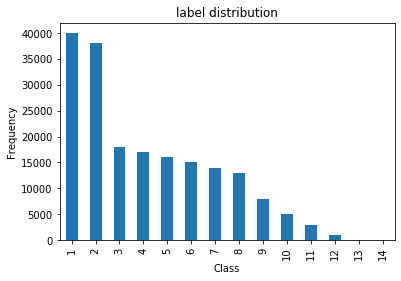

In [4]:
# 类别分布图

import matplotlib.pyplot as plt

count_classes = step1_df.label.value_counts()
count_classes.plot(kind = 'bar')
plt.title("label distribution")
plt.xlabel("Class")
plt.ylabel("Frequency");

In [5]:
# 查看数字类别对应的名称

!cat original_dataset/classes.txt

Company
EducationalInstitution
Artist
Athlete
OfficeHolder
MeanOfTransportation
Building
NaturalPlace
Village
Animal
Plant
Album
Film
WrittenWork


In [6]:
# 创建从整数索引到类标签的字典映射

index_to_label = {} 
with open("original_dataset/classes.txt") as f:
    for i,label in enumerate(f.readlines()):
        index_to_label[str(i+1)] = label.strip()
print(index_to_label)

{'1': 'Company', '2': 'EducationalInstitution', '3': 'Artist', '4': 'Athlete', '5': 'OfficeHolder', '6': 'MeanOfTransportation', '7': 'Building', '8': 'NaturalPlace', '9': 'Village', '10': 'Animal', '11': 'Plant', '12': 'Album', '13': 'Film', '14': 'WrittenWork'}


## Step 2 - 数据预处理

1.去掉空行；2.大小写统一；3.分词；4.转化为BlazingText的数据集格式

预处理后的数据集已经可以作为Baseline实验的数据集

In [7]:
from random import shuffle
import multiprocessing
from multiprocessing import Pool
import csv
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
# 创建从整数索引到以“__label__”开头的类标签的字典映射

index_to_label_final = {}
for key in index_to_label:
    index_to_label_final[key] = "__label__" + str(index_to_label[key]) 

print(index_to_label_final) 

{'1': '__label__Company', '2': '__label__EducationalInstitution', '3': '__label__Artist', '4': '__label__Athlete', '5': '__label__OfficeHolder', '6': '__label__MeanOfTransportation', '7': '__label__Building', '8': '__label__NaturalPlace', '9': '__label__Village', '10': '__label__Animal', '11': '__label__Plant', '12': '__label__Album', '13': '__label__Film', '14': '__label__WrittenWork'}


In [10]:

def tokenize(series):
    for index, value in series.items():
        series[index] = nltk.word_tokenize(value.lower())
    return series

def preprocess(step1_df):
    
    step1_df = step1_df.dropna(axis=0) 
    
    step2_df = pd.DataFrame()
    step2_df['label'] = step1_df['label']
    step2_df['label'] = step2_df['label'].map(str).map(index_to_label_final)
    step2_df['sentence'] = step1_df["title"].map(str) +","+ step1_df["abstract"].map(str)
    step2_df['sentence'] = tokenize(step2_df['sentence'])
    return step2_df

step2_df = preprocess(step1_df)
step2_df.head(10)

,label,sentence
0,__label__Company,"E. D. Abbott Ltd, Abbott of Farnham E D Abbott..."
1,__label__Company,"Schwan-Stabilo, Schwan-STABILO is a German mak..."
2,__label__Company,"Q-workshop, Q-workshop is a Polish company loc..."
3,__label__Company,"Marvell Software Solutions Israel, Marvell Sof..."
4,__label__Company,"Bergan Mercy Medical Center, Bergan Mercy Medi..."
5,__label__Company,"The Unsigned Guide, The Unsigned Guide is an o..."
6,__label__Company,"Rest of the world, Within sports and games pla..."
7,__label__Company,"Globoforce, Globoforce is a multinational comp..."
8,__label__Company,"Rompetrol, The Rompetrol Group N.V. is a Roman..."
9,__label__Company,"Wave Accounting, Wave is the brand name for a ..."


In [11]:
# 预处理后的数据集作为baseline实验的数据集

step2_df.to_csv("baseline_dataset/dataset_baseline.csv", sep=" ", header=0, index=0)

## Step 3 - 处理样本不均衡

解决办法：对于文本数据，我们采取 回译 和 EDA 这两种过采样方法对少样本进行增强。

### 数据分析

要对上述样本进行样本增强的同时不能太破坏原有数据的规律，即，各个类别的数量变化大致趋势要保持一致。

原数据集label1的数量最多为4w条，label14的数量最少为15条，并且从label1到label14一直呈数量递减。

增强后的数据的目标：最少数量类别增强后要在最大数量类别的1/3到1/2之间。也就是40000/3到40000/2之间，也就是133333到20000之间。

如何保持原有数据规律：原有数据大致呈等差递减数列，因此增强后的数据也保持等差递减。公差在(40000-40000/3)/13到(40000-40000/2)/13之间，也就是2051到1538之间，便于计算取值2000作为公差。

因此对于本项目中的数据增强，希望达到的大致数据：首项为40000，公差为2000的等差数列。y(x)=40000-2000(x-1)。增强后数量最少的label14的数量大致为14000

### 过采样方法一：回译

回译：将文本翻译成另一种语言，再翻译回来。对翻译再进行去重，可以达到样本增加n倍效果，并且能够保持文本语义信息不变。

In [16]:
# 采用 回译 处理样本不均衡

import random
import boto3

translate_client = boto3.client('translate')

# AWS Translate除了english(en)之外还支持54种语言
available_lang = ["af","sq","am","ar","az","bn","bs","bg","zh","zh-TW","hr","cs","da","fa-AF","nl","et","fi","fr","fr-CA","ka","de","el","ha","he",
                  "hi","hu","id","ja","ko","lv","ms","no","fa","ps","pl","pt","ro","ru","sr","sk","sl","so","es","es-MX","sw","sv","tl","ta","th","tr","uk","ur","vi"]

'''
回译函数
'''
def back_translate(text, sourceLanguageCode, targetLanguageCode):
    response1 = translate_client.translate_text(
        Text = text,
        SourceLanguageCode = sourceLanguageCode,
        TargetLanguageCode = targetLanguageCode
    )
    translation_text = response1['TranslatedText']
#     print(translation_text)
    response2 = translate_client.translate_text(
        Text = text,
        SourceLanguageCode = targetLanguageCode,
        TargetLanguageCode = sourceLanguageCode
    )
    return response2['TranslatedText']

'''
对54次回译结果去重，并从set结果中选择n个包含原句子的句子
'''
def get_translation_set(text, n):
    translation_set = set()
    translation_set.add(text)
    for language in available_lang:
        result = back_translate(text, "en", language)
        translation_set.add(result)
    translation_set.remove(text)
    if n-1 <= len(translation_set):
        translation_set = set(random.sample(translation_set, n-1))
    translation_set.add(text)
    return translation_set

'''
得到对应label的回译list
return: [[label,sent1],[label,sent2]...]
'''
def get_label_translation_list(label, sentences, n):
    result = []
    for text in sentences:
        translation_set = get_translation_set(text, n)
        for tanslation in translation_set:
            result.append([label,tanslation])
    return result

In [17]:
# 简单测试回译效果

label = "__label__Company"
sentences = ["E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929."]
print(get_label_translation_list(label, sentences, 5))

[['__label__Company', 'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trading under that name from 1929.'], ['__label__Company', 'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited is a British coachbuilding business based in Farnham Surrey Trading Under The name from 1929.'], ['__label__Company', 'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British business coachbuilding based in Farnham Surrey trading under that name from 1929.'], ['__label__Company', 'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based on Farnham Surrey trading under that name from 1929.'], ['__label__Company', 'E. D. Abbott Ltd, Abbott of Farnham E D Abbott Limited was a British coachbuilding business based in Farnham Surrey trade under that name from 1929.']]


In [18]:
# 计算回译阶段需要增强的倍数 n1 值

import math

'''
根据label名字反推出id
'''
def get_num_from_name(name):
    num = 0;
    for key in index_to_label_final:
        if index_to_label_final[key] == name:
            num = int(key)
    return num;

'''
计算n1值
'''
def calcu_n1(name):
    num = get_num_from_name(name)
    
    current_num = group.label.value_counts().iloc[0]
    expected_num = 40000-2000*(num-1)
        
    n1 = math.floor(expected_num/current_num)
    return n1

In [19]:
# 开始进行分组回译处理
# 测试阶段为了效率，只对 label13 和 label14 进行回译处理

grouped = step2_df.groupby('label')

group1 = grouped.get_group("__label__Company")
back_translate_df = pd.DataFrame(group1)

for name, group in grouped:
    num = get_num_from_name(name)
    
    if num != 1:
        print ("processing: " + str(num) + "," + name)

        n1 = calcu_n1(name)
        if n1 > 100:
            label_translation_list = get_label_translation_list(name, group.sentence, n1)
            group_df = pd.DataFrame(label_translation_list,columns=['label','sentence'])
            back_translate_df = back_translate_df.append(group_df)
        else:
            back_translate_df = back_translate_df.append(pd.DataFrame(group))

processing: 12,__label__Album
processing: 10,__label__Animal
processing: 3,__label__Artist
processing: 4,__label__Athlete
processing: 7,__label__Building
processing: 2,__label__EducationalInstitution
processing: 13,__label__Film
processing: 6,__label__MeanOfTransportation
processing: 8,__label__NaturalPlace
processing: 5,__label__OfficeHolder
processing: 11,__label__Plant
processing: 9,__label__Village
processing: 14,__label__WrittenWork


__label__Company                   40000
__label__EducationalInstitution    38000
__label__Artist                    18000
__label__Athlete                   17000
__label__OfficeHolder              16000
__label__MeanOfTransportation      15000
__label__Building                  14000
__label__NaturalPlace              13000
__label__Village                    8000
__label__Animal                     5000
__label__Film                       3214
__label__Plant                      3000
__label__Album                       900
__label__WrittenWork                 748
Name: label, dtype: int64


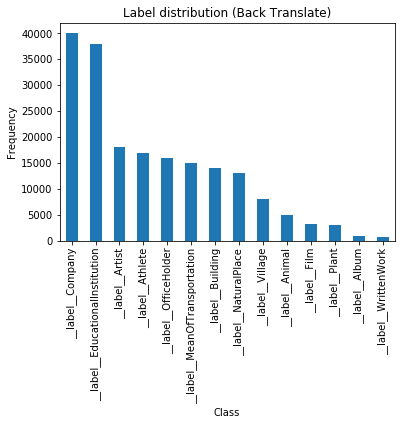

In [21]:
# 查看回译后的数据分布

back_tanslate_classes = back_translate_df.label.value_counts()

back_tanslate_classes.plot(kind = 'bar')
plt.title("Label distribution (Back Translate)")
plt.xlabel("Class")
plt.ylabel("Frequency");

print(back_tanslate_classes)

### 过采样方法二：EDA

EDA：同义词替换、随机插入、随机交换、随机删除

In [25]:
# 下载 eda 工具

!git clone https://github.com/jasonwei20/eda_nlp.git

Cloning into 'eda_nlp'...
remote: Enumerating objects: 379, done.
remote: Total 379 (delta 0), reused 0 (delta 0), pack-reused 379
Receiving objects: 100% (379/379), 20.41 MiB | 7.57 MiB/s, done.
Resolving deltas: 100% (183/183), done.


In [23]:
# 因为每个 group 都要进行不同级别的 EDA 处理，这里简单得把每个 group 单独保存为了一个文件

eda_grouped = back_translate_df.groupby('label')

for name, group in eda_grouped:
    every_group_df = pd.DataFrame(group)
    filename = "data_groups/group" + name + ".csv"
    every_group_df.to_csv(filename, sep="\t", header=0, index=0)

In [55]:
# 计算 EDA 阶段需要增强的倍数 n2 值

import math

'''
计算n2值
'''
def calcu_n2(name):
    num = get_num_from_name(name)
    
    current_num = group.label.value_counts().iloc[0]
    expected_num = 40000-2000*(num-1)
        
    n2 = math.floor(expected_num/current_num)-1
    return n2

In [36]:
import nltk

nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [56]:
# EDA工具对每一组文件进行处理

from shutil import copyfile

groups = back_translate_df.groupby('label')

for name, group in groups:
    num = get_num_from_name(name)
    n2 = calcu_n2(name)
    filename = "group" + name + ".csv"
    if n2 > 0:
        !python eda_nlp/code/augment.py --input=data_groups/$filename --num_aug=$n2 --alpha=0.1
    else:
        copyfile("data_groups/" + filename, "data_groups/" + "eda_" + filename)
        print("copied file: " + filename)


generated augmented sentences with eda for data_groups/group__label__Album.csv to data_groups/eda_group__label__Album.csv with num_aug=19
generated augmented sentences with eda for data_groups/group__label__Animal.csv to data_groups/eda_group__label__Animal.csv with num_aug=3
generated augmented sentences with eda for data_groups/group__label__Artist.csv to data_groups/eda_group__label__Artist.csv with num_aug=1
generated augmented sentences with eda for data_groups/group__label__Athlete.csv to data_groups/eda_group__label__Athlete.csv with num_aug=1
generated augmented sentences with eda for data_groups/group__label__Building.csv to data_groups/eda_group__label__Building.csv with num_aug=1
generated augmented sentences with eda for data_groups/group__label__Company.csv to data_groups/eda_group__label__Company.csv with num_aug=9
generated augmented sentences with eda for data_groups/group__label__EducationalInstitution.csv to data_groups/eda_group__label__EducationalInstitution.csv wit

In [68]:
# 合并EDA处理后的各个文件

import os

step3_df = pd.DataFrame(columns=['label', 'sentence'])

for root,dirs,files in os.walk(r"data_groups"):
    for file in files:
        #获取文件路径
        file_path = os.path.join(root,file)

        if "eda" in file_path:
            print(file_path)
            file_df = pd.read_csv(file_path, sep="\t", header=0, names=['label', 'sentence'])
            step3_df = step3_df.append(file_df)

data_groups/eda_group__label__MeanOfTransportation.csv
data_groups/eda_group__label__WrittenWork.csv
data_groups/eda_group__label__Film.csv
data_groups/eda_group__label__Album.csv
data_groups/eda_group__label__Village.csv
data_groups/eda_group__label__Animal.csv
data_groups/eda_group__label__EducationalInstitution.csv
data_groups/eda_group__label__Athlete.csv
data_groups/eda_group__label__Artist.csv
data_groups/eda_group__label__Building.csv
data_groups/eda_group__label__OfficeHolder.csv
data_groups/eda_group__label__NaturalPlace.csv
data_groups/eda_group__label__Plant.csv
data_groups/eda_group__label__Company.csv


__label__Company                   39999
__label__EducationalInstitution    37999
__label__Artist                    35999
__label__Athlete                   33999
__label__OfficeHolder              31999
__label__MeanOfTransportation      29999
__label__Building                  27999
__label__NaturalPlace              25999
__label__Village                   23999
__label__Animal                    19999
__label__Plant                     17999
__label__Album                     17099
__label__Film                      16069
__label__WrittenWork               13463
Name: label, dtype: int64


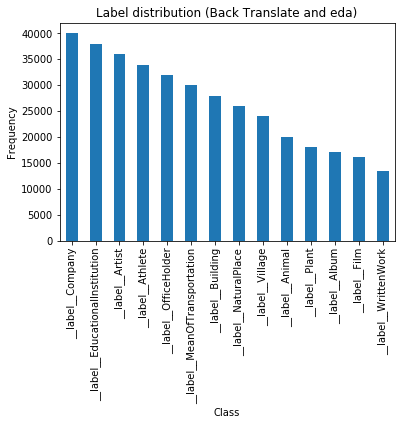

In [69]:
# 查看 EDA 处理后的样本分布

translate_eda_classes = step3_df.label.value_counts()
translate_eda_classes.plot(kind = 'bar')
plt.title("Label distribution (Back Translate and eda)")
plt.xlabel("Class")
plt.ylabel("Frequency");

print(translate_eda_classes)

In [70]:
step3_df.to_csv("sampling_dataset/dataset_oversampling.csv", sep=" ", header=0, index=0)

## Step4 - 模型训练

对过采样处理后的样本进行文本分类模型的训练。

算法选择Sagemaker预置的BlazingText算法中的指导型文本分类模式。

### 4.1 准备数据

In [72]:
# 划分训练集和测试集

import numpy as np
from sklearn.model_selection import train_test_split

sampling_train, sampling_test = train_test_split(step3_df, test_size=0.15)
sampling_train.to_csv("sampling_dataset/sampling_train.csv", sep=" ", header=0, index=0)
sampling_test.to_csv("sampling_dataset/sampling_test.csv", sep=" ", header=0, index=0)

In [73]:
# 上传数据到 S3

train_channel = prefix + '/sampling' + '/train'
validation_channel = prefix + '/sampling' + '/validation'

sess.upload_data(path='sampling_dataset/sampling_train.csv', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='sampling_dataset/sampling_test.csv', bucket=bucket, key_prefix=validation_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_validation_data = 's3://{}/{}'.format(bucket, validation_channel)

In [74]:
s3_output_location = 's3://{}/{}/sampling/output'.format(bucket, prefix)

In [75]:
region_name = boto3.Session().region_name

In [ ]:
train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')

validation_data = sagemaker.session.s3_input(s3_validation_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')

data_channels = {'train': train_data, 'validation': validation_data}

### 4.2 设置超参数优化作业

In [ ]:
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

In [77]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

In [78]:
bt_model.set_hyperparameters(
                            mode="supervised",
                            epochs=10,
                            min_count=2,
                            early_stopping=True,
                            patience=4,
                            min_epochs=5)

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {'learning_rate': ContinuousParameter(0.03, 0.06),
                         'vector_dim': IntegerParameter(100, 200),
                         'word_ngrams': IntegerParameter(1, 3)}

objective_metric_name = 'validation:accuracy'

tuner = HyperparameterTuner(bt_model,
                            objective_metric_name,
                            hyperparameter_ranges,
                            objective_type='Maximize',
                            max_jobs=9,
                            max_parallel_jobs=3)

### 4.3 启动超参数优化作业

In [ ]:
bt_model.fit(inputs=data_channels, job_name="hyperparameter-oversampling-job", logs=True)

## Step 5 - 模型部署

对采样后的模型进行部署，并且用测试集进行测试，查看每一个分类的输出指标

In [81]:
# 过采样后的模型部署

sampling_classifier = bt_model.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')

-------------!

## Step 7 - 模型评估和测试

In [82]:
# 样本不均衡处理后的模型测试指标

from sklearn.metrics import classification_report
import json

sentenses = sampling_test['sentence'].tolist()
# print(sentenses)

payload = {"instances" : sentenses}
response = sampling_classifier.predict(json.dumps(payload))
predictions = json.loads(response)
# print(predictions)

predict_label = []
for one in predictions:
#     print(one['label'][0])
    predict_label.append(one['label'][0])
# print(predict_label)

real_label = sampling_test['label'].tolist()
# print(real_label)

print(classification_report(real_label, predict_label))

                                 precision    recall  f1-score   support

                 __label__Album       1.00      1.00      1.00      2527
                __label__Animal       0.99      1.00      1.00      3031
                __label__Artist       0.98      0.99      0.99      5407
               __label__Athlete       1.00      1.00      1.00      5032
              __label__Building       0.99      0.99      0.99      4270
               __label__Company       0.98      0.99      0.99      6010
__label__EducationalInstitution       0.99      0.99      0.99      5611
                  __label__Film       1.00      1.00      1.00      2502
  __label__MeanOfTransportation       1.00      0.99      0.99      4419
          __label__NaturalPlace       0.99      0.99      0.99      3921
          __label__OfficeHolder       0.99      0.98      0.99      4774
                 __label__Plant       1.00      0.99      0.99      2756
               __label__Village       1.00      1.